In [4]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

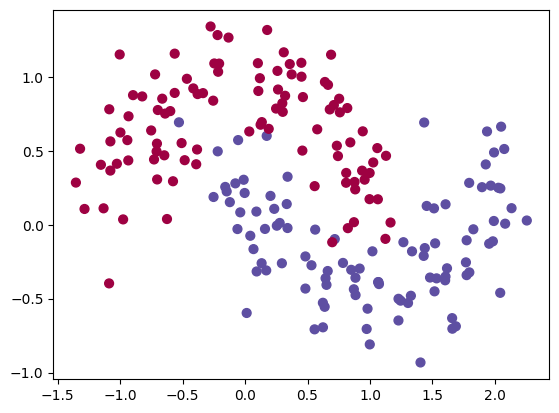

ValueError: operands could not be broadcast together with shapes (200,) (200,2) 

In [ ]:
#__author__ = 'tan_nguyen'
def generate_data():
    '''
    generate data
    :return: X: input data, y: given labels
    '''
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y

def plot_decision_boundary(pred_func, X, y):
    '''
    plot the decision boundary
    :param pred_func: function used to predict the label
    :param X: input data
    :param y: given labels
    :return:
    '''
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()

########################################################################################################################
########################################################################################################################
# YOUR ASSSIGMENT STARTS HERE
# FOLLOW THE INSTRUCTION BELOW TO BUILD AND TRAIN A 3-LAYER NEURAL NETWORK
########################################################################################################################
########################################################################################################################
class NeuralNetwork(object):
    """
    This class builds and trains a neural network
    """
    def __init__(self, nn_input_dim, nn_hidden_dim , nn_output_dim, actFun_type='tanh', reg_lambda=0.01, seed=0):
        '''
        :param nn_input_dim: input dimension
        :param nn_hidden_dim: the number of hidden units
        :param nn_output_dim: output dimension
        :param actFun_type: type of activation function. 3 options: 'tanh', 'sigmoid', 'relu'
        :param reg_lambda: regularization coefficient
        :param seed: random seed
        '''
        self.nn_input_dim = nn_input_dim
        self.nn_hidden_dim = nn_hidden_dim
        self.nn_output_dim = nn_output_dim
        self.actFun_type = actFun_type
        self.reg_lambda = reg_lambda
        
        # initialize the weights and biases in the network
        np.random.seed(seed)
        self.W1 = np.random.randn(self.nn_input_dim, self.nn_hidden_dim) / np.sqrt(self.nn_input_dim)
        self.b1 = np.zeros((1, self.nn_hidden_dim))
        self.W2 = np.random.randn(self.nn_hidden_dim, self.nn_output_dim) / np.sqrt(self.nn_hidden_dim)
        self.b2 = np.zeros((1, self.nn_output_dim))

    def actFun(self, z, type):
        '''
        actFun computes the activation functions
        :param z: net input
        :param type: Tanh, Sigmoid, or ReLU
        :return: activations
        '''
        type = str(type).strip().lower()
        if type == 'tanh':
            return np.tanh(z)
        elif type == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif type == 'relu':
            return np.maximum(0, z)
        else:
            raise ValueError("Invalid type: type must be 'Tanh', 'Sigmoid', or 'ReLU'.")
        # YOU IMPLMENT YOUR actFun HERE
        

        return None

    def diff_actFun(self, z, type):
        '''
        diff_actFun computes the derivatives of the activation functions wrt the net input
        :param z: net input
        :param type: Tanh, Sigmoid, or ReLU
        :return: the derivatives of the activation functions wrt the net input
        '''

        # YOU IMPLEMENT YOUR diff_actFun HERE
        type = str(type).strip().lower()
        if type == 'tanh':
            return 1 - np.tanh(z) ** 2
        elif type == 'sigmoid':
            s = 1 / (1 + np.exp(-z))
            return s * (1 - s)
        elif type == 'relu':
            return (z > 0).astype(float)
        else:
            raise ValueError("Invalid type: type must be tanh, Sigmoid or ReLU.")


    def feedforward(self, X, actFun):
        '''
        feedforward builds a 3-layer neural network and computes the two probabilities,
        one for class 0 and one for class 1
        :param X: input data
        :param actFun: activation function
        :return:
        '''

        # YOU IMPLEMENT YOUR feedforward HERE

        self.z1 = X @ self.W1 + self.b1
        self.a1 = actFun(self.z1)
        self.z2 =  self.a1 @ self.W2 + self.b2

        exp_scores = np.exp(self.z2)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return None

    def calculate_loss(self, X, y):
        '''
        calculate_loss computes the loss for prediction
        :param X: input data
        :param y: given labels
        :return: the loss for prediction
        '''
        num_examples = len(X)
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        # Calculating the loss

        # YOU IMPLEMENT YOUR CALCULATION OF THE LOSS HERE

        N, C = self.probs.shape


        eps = 1e-12
        y_onehot = np.eye(C)[y]  
        data_loss = -np.sum(y_onehot * np.log(self.probs + eps))/ num_examples

        # Add regulatization term to loss (optional)
        data_loss += self.reg_lambda / 2 * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        return data_loss

    def predict(self, X):
        '''
        predict infers the label of a given data point X
        :param X: input data
        :return: label inferred
        '''
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        return np.argmax(self.probs, axis=1)

    def backprop(self, X, y):
        '''
        backprop implements backpropagation to compute the gradients used to update the parameters in the backward step
        :param X: input data
        :param y: given labels
        :return: dL/dW1, dL/b1, dL/dW2, dL/db2
        '''

        # IMPLEMENT YOUR BACKPROP HERE
        num_examples = len(X)
        delta3 = self.probs
        delta3[range(num_examples), y] -= 1

        dW2 = self.a1.T @ delta3
        db2 = delta3.sum(axis=0)

        # Hidden layer (layer 2)
        delta2 = (delta3 @ self.W2.T) * self.diff_actFun(self.z1, type=self.actFun_type)
        dW1 = X.T @ delta2
        db1 = delta2.sum(axis=0)
        # dW2 = dL/dW2
        # db2 = dL/db2
        # dW1 = dL/dW1
        # db1 = dL/db1
        return dW1, dW2, db1, db2

    def fit_model(self, X, y, epsilon=0.01, num_passes=20000, print_loss=True):
        '''
        fit_model uses backpropagation to train the network
        :param X: input data
        :param y: given labels
        :param num_passes: the number of times that the algorithm runs through the whole dataset
        :param print_loss: print the loss or not
        :return:
        '''
        # Gradient descent.
        for i in range(0, num_passes):
            # Forward propagation
            self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
            # Backpropagation
            dW1, dW2, db1, db2 = self.backprop(X, y)

            # Add regularization terms (b1 and b2 don't have regularization terms)
            dW2 += self.reg_lambda * self.W2
            dW1 += self.reg_lambda * self.W1

            # Gradient descent parameter update
            self.W1 += -epsilon * dW1
            self.b1 += -epsilon * db1
            self.W2 += -epsilon * dW2
            self.b2 += -epsilon * db2

            # Optionally print the loss.
            # This is expensive because it uses the whole dataset, so we don't want to do it too often.
            if print_loss and i % 1000 == 0:
                print("Loss after iteration %i: %f" % (i, self.calculate_loss(X, y)))

    def visualize_decision_boundary(self, X, y):
        '''
        visualize_decision_boundary plots the decision boundary created by the trained network
        :param X: input data
        :param y: given labels
        :return:
        '''
        plot_decision_boundary(lambda x: self.predict(x), X, y)

def main():
    # # generate and visualize Make-Moons dataset
    X, y = generate_data()
    plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
    plt.show()

    model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 , nn_output_dim=2, actFun_type='tanh')
    model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 , nn_output_dim=2, actFun_type='tanh')
    model.fit_model(X,y)
    model.visualize_decision_boundary(X,y)

if __name__ == "__main__":
    main()